# ResNet50 Pretrained Network no Fine Tuning  

In this run for the ResNet50, we froze all layers but the last 10 and added two dense layers after the conv_base.

Results>

Best Epoch: 45

test acc: 0.80666

test loss: 3.62110

f1_score: 0.803189

Precision: 0.81789

Recall: 0.789

ROC AUC: 0.80666

---Training:  seconds --- 20697,7 s

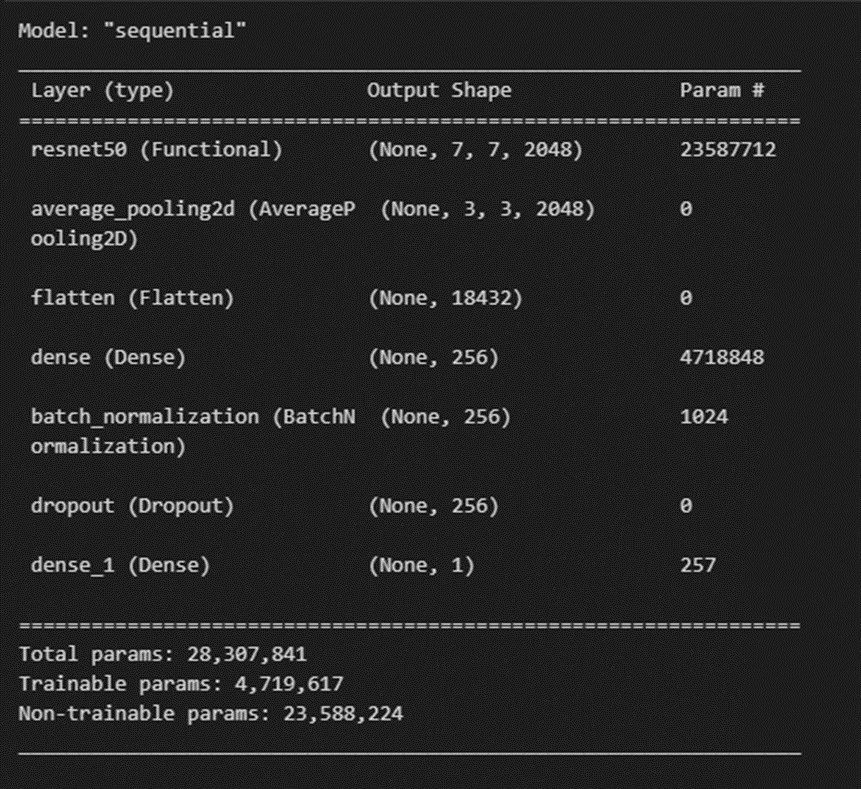

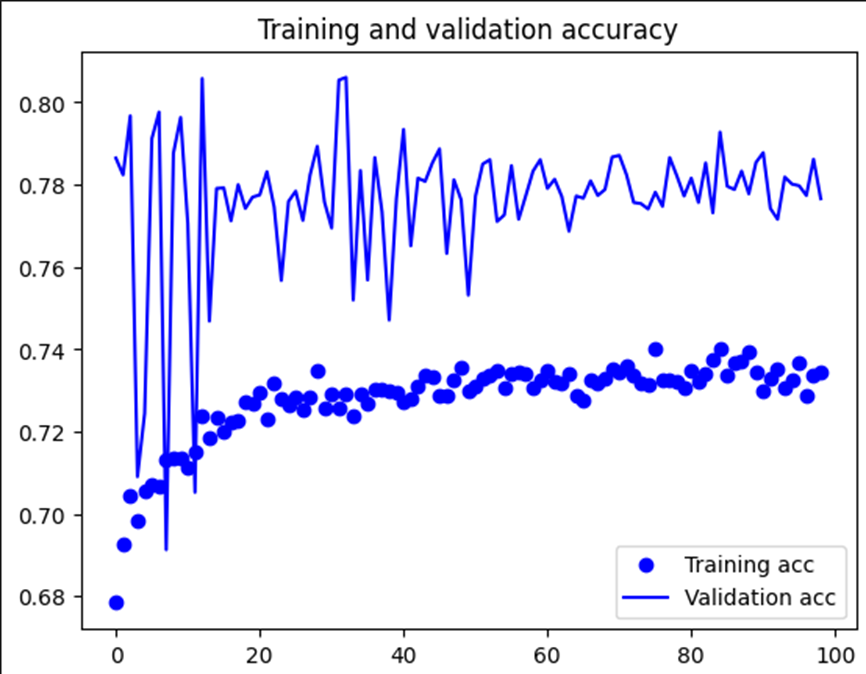

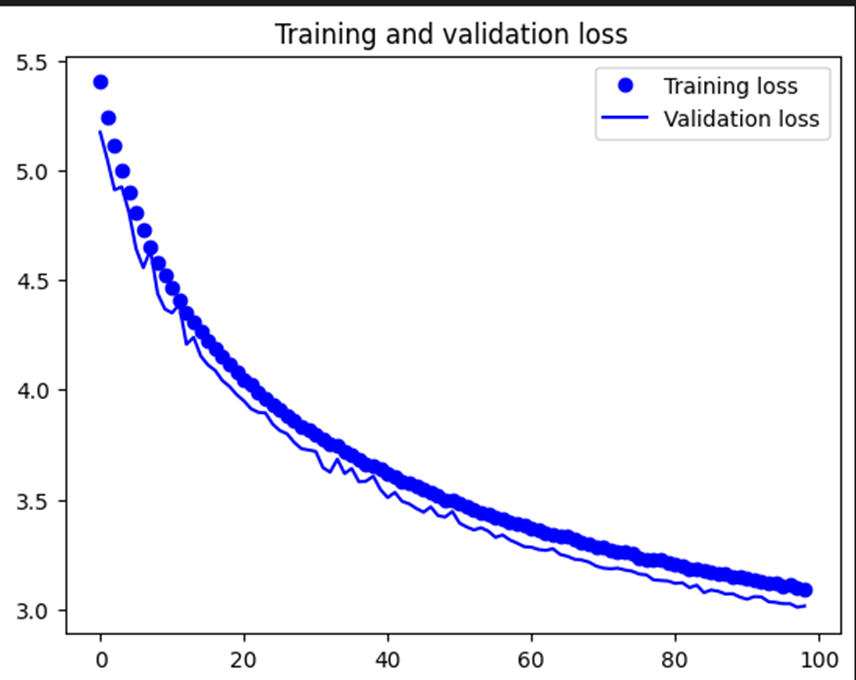

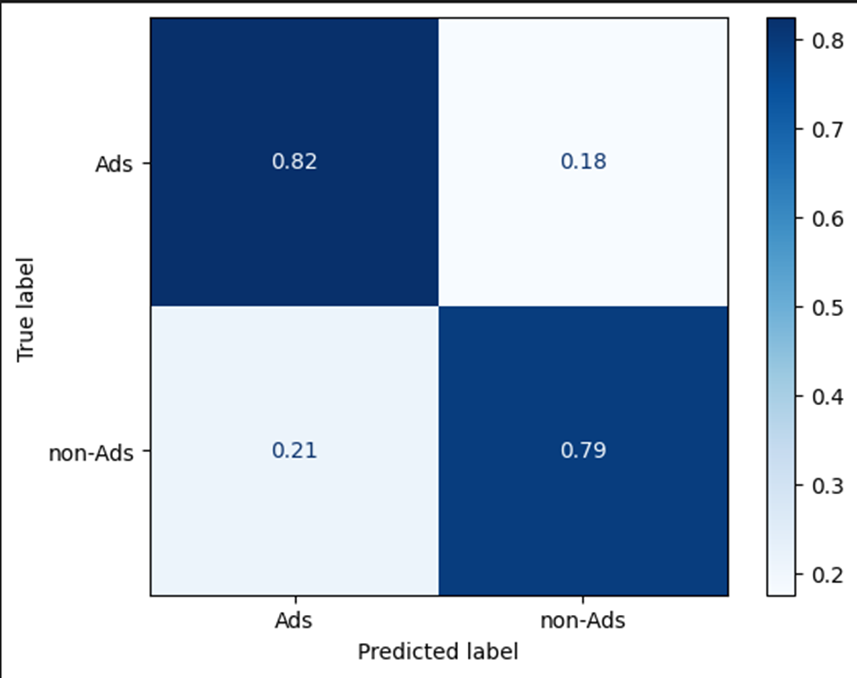

In [90]:
#!pip install "tensorflow<2.11"

In [91]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [92]:
#!pip install torchvision

In [93]:

#!pip list
import torch

In [94]:
#!nvidia-smi

In [95]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [96]:
# add headings with ##(space) on the markdowns

In [97]:
#!pip install tensorflor keras

In [98]:
import tensorflow as tf
import os

In [99]:
!nvidia-smi

Sun Jun 23 11:32:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
| 69%   54C    P8              18W / 125W |   5542MiB /  6144MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [100]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [101]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [102]:
#! nvidia-smi

In [103]:
#!pip install opencv-python

## Imports

In [104]:
import tensorflow as tf
import os
import cv2
import imghdr

In [105]:
import numpy as np
from matplotlib import pyplot as plt

In [106]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 0
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [107]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [108]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [109]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [110]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir



'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [111]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [112]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [113]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [114]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [115]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [116]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [117]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [118]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [119]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [120]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [121]:
from keras.preprocessing.image import ImageDataGenerator
## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)


# train_datagen = ImageDataGenerator(
#     rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model ResNet50

In [122]:
import keras
from keras.models import load_model


The ResNEt50 model
https://datagen.tech/guides/computer-vision/resnet-50/#


In [123]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [124]:
conv_base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We will add a dense layer after our conv_base NN

In [125]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D

modelPreTRes = models.Sequential()
modelPreTRes.add(conv_base)
modelPreTRes.add(layers.AveragePooling2D())
modelPreTRes.add(layers.Flatten())
modelPreTRes.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTRes.add(BatchNormalization())
modelPreTRes.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTRes.add(layers.Dense(1, activation='sigmoid'))

In [126]:
modelPreTRes.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)              

# Fine Tuning

In [127]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [128]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(modelPreTRes.trainable_weights))

This is the number of trainable layers before freezing the conv base: 218


In [129]:
conv_base.trainable = False

In [130]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTRes.trainable_weights))

This is the number of trainable weights before freezing the conv base: 6


In [131]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [132]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTRes.trainable_weights))

This is the number of trainable weights before freezing the conv base: 6


In [133]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [134]:
modelPreTRes.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [135]:
modelPreTRes.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [136]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelResNetNoFT-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [137]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [138]:
print(TrainingConfig.EPOCHS)

100


In [139]:
import time
start_time = time.time()

In [140]:
histPreT = modelPreTRes.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) #  epochs 10 are over fitting. early stop at?

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.6154 - accuracy: 0.6505
Epoch 1: val_accuracy improved from -inf to 0.75750, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelResNetNoFT-01-0.7575.keras
329/329 [==============================] - 215s 646ms/step - loss: 5.6154 - accuracy: 0.6505 - val_loss: 5.3759 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.4007 - accuracy: 0.6784
Epoch 2: val_accuracy improved from 0.75750 to 0.78645, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelResNetNoFT-02-0.7864.keras
329/329 [==============================] - 212s 645ms/step - loss: 5.4007 - accuracy: 0.6784 - val_loss: 5.1724 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.2428 - accuracy: 0.6926
Epoch 3: val_accuracy did not improve from 0.78645
329/329 [============================

In [141]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 21121.744196891785 seconds ---


In [142]:
#modelPreTRes.save(os.path.join('models/Latest','Pretrained_RenNet50_ad_class_with_Aug.h5'))

In [143]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [144]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [145]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_ResNet50_FT0_2', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [146]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 34


In [147]:
START_PLOT_FROM_EPOCH= 1

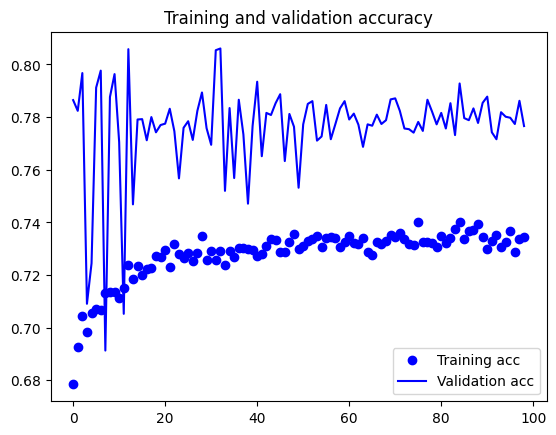

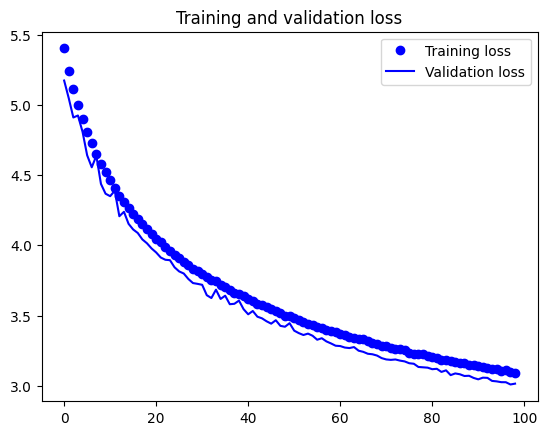

In [148]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [149]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 34


# Loading best epoch in our model using the checkpoints

In [150]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [151]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-34-0.8061.keras


In [152]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [153]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'modelResNetNoFT-01-0.7575.keras',
 'modelResNetNoFT-02-0.7864.keras',
 'modelResNetNoFT-04-0.7967.keras',
 'modelResNetNoFT-08-0.7976.keras',
 'modelResNetNoFT-14-0.8058.keras',
 'modelResNetNoFT-34-0.8061.keras']

In [155]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelResNetNoFT-34-0.8061.keras') 
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)              

## Evaluate

In [156]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [157]:
start_time = time.time()

In [158]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.EPOCHS,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 6000 images belonging to 2 classes.
60/60 [==============================] - 22s 320ms/step - loss: 3.6211 - accuracy: 0.8067
test acc: 0.8066666722297668
test loss: 3.6211087703704834


In [159]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 22.743204593658447 Training set > seconds ---


In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [161]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

4/4 [==============================] - 0s 99ms/step


In [162]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [163]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2473,  527],
       [ 633, 2367]], dtype=int64)

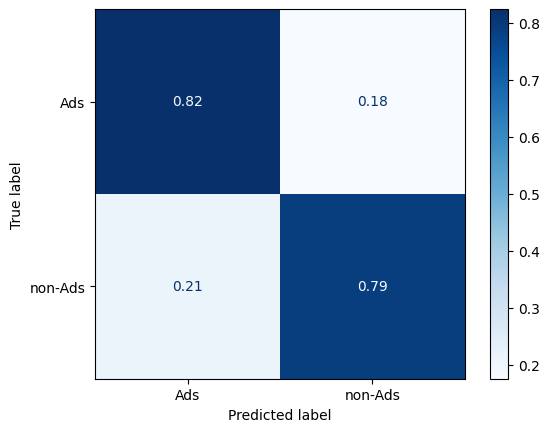

In [164]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [165]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [166]:

f1_score(true_labels, predicted_labels)

0.803189684424839

In [167]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8178991015894955

In [168]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.789

In [169]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.806667
